In [1]:
import xarray as xr
import numpy as np
from geopy.distance import geodesic
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gsw
import cmocean

In [2]:
vels=xr.open_dataset('Z:/adcp-uv.nc').load()
vels

<xarray.Dataset>
Dimensions:  (cast: 36, z: 539, lat: 36, lon: 36)
Coordinates:
  * lat      (lat) float64 -32.1 -30.27 -30.24 -30.2 ... -28.26 -28.26 -28.34
  * lon      (lon) float64 153.2 153.7 153.8 153.8 ... 153.9 153.9 153.9 154.0
  * cast     (cast) object ' 1' ' 2' ' 3' ' 4' ' 6' ... '35' '36' '37' '39' '40'
  * z        (z) float64 8.179 16.36 24.54 32.71 ... 4.392e+03 4.4e+03 4.408e+03
Data variables:
    u        (cast, z) float64 0.8044 0.8302 0.8634 0.9168 ... nan nan nan nan
    v        (cast, z) float64 0.4254 0.4184 0.3779 0.335 ... nan nan nan nan

In [ ]:
multi=xr.open_dataset('Z:/Solitary_Island_Canyon_High_Res_Bathy.nc')
multi

In [ ]:
def ctd_casts_bathy(transect_casts):
    # Create the plot
    fig = plt.figure(figsize=(18, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([153.5, 154, -30.3, -29.9])
    im = ax.pcolormesh(multi.lon,multi.lat,multi.Band1,cmap='cmo.gray',zorder=1)
    ax.contour(multi.lon,multi.lat,multi.Band1,levels=np.arange(-4000,-100,500),colors='k',linewidths=.75,linestyles='solid',zorder=2)
    ax.contour(multi.lon,multi.lat,multi.Band1,levels=[-3000,-1000],colors='red',linewidths=1,linestyles='solid',zorder=3)
    im.set_clim(-5000,0)

    # Add gridlines
    gl=ax.gridlines(draw_labels=True)
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = True
    gl.bottom_labels = True


    # Show the plot
    plt.show()

# Extract cast, lat, lon from vels dataset
casts = vels['cast'].values.astype(int)
lats = vels['lat'].values
lons = vels['lon'].values

ctd_casts_bathy(transect_casts)

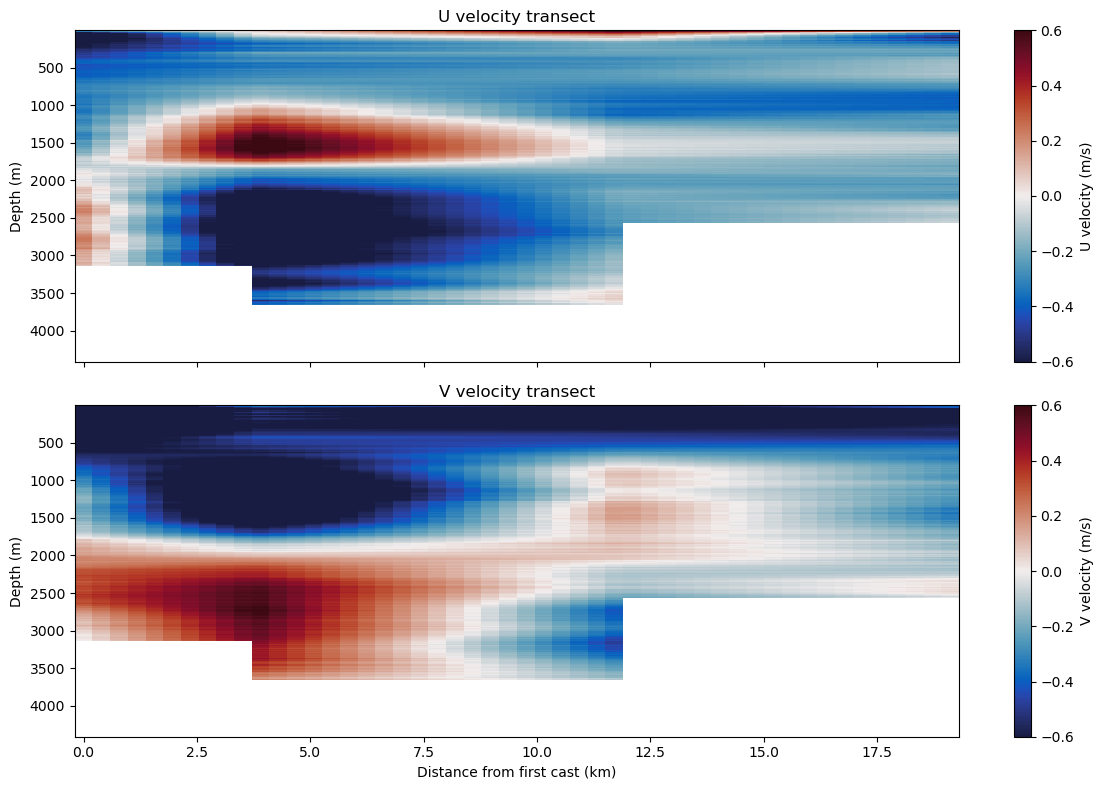

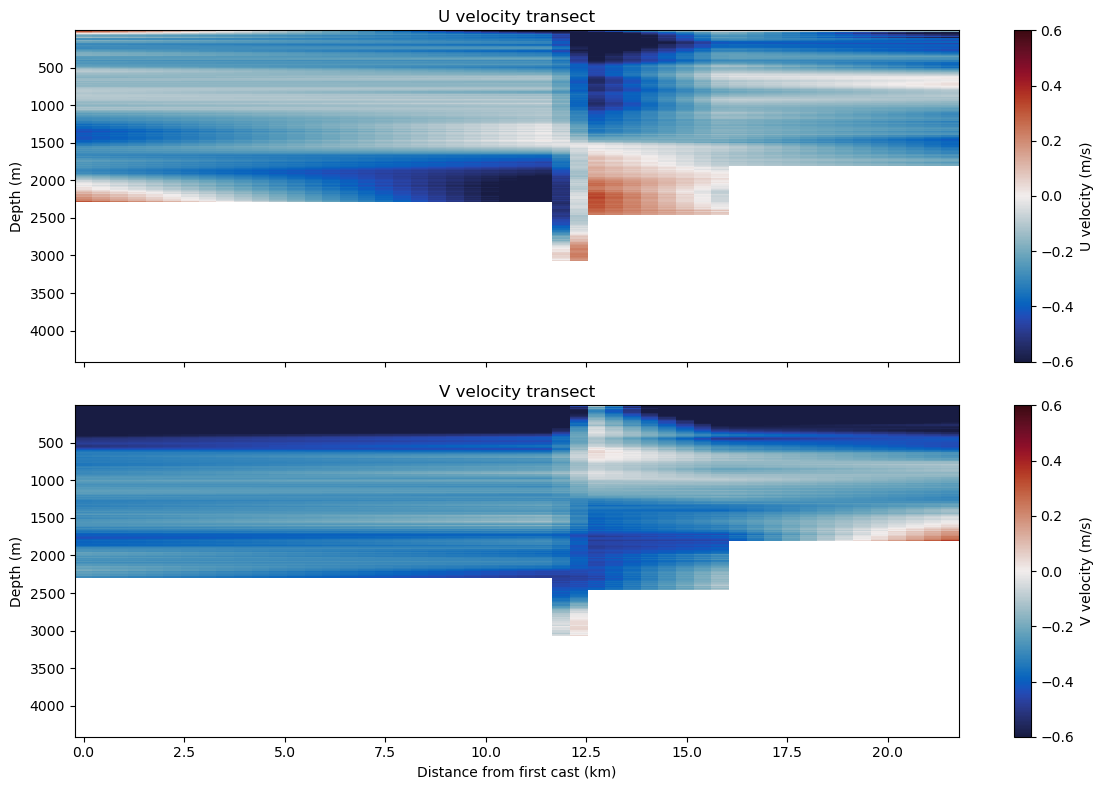

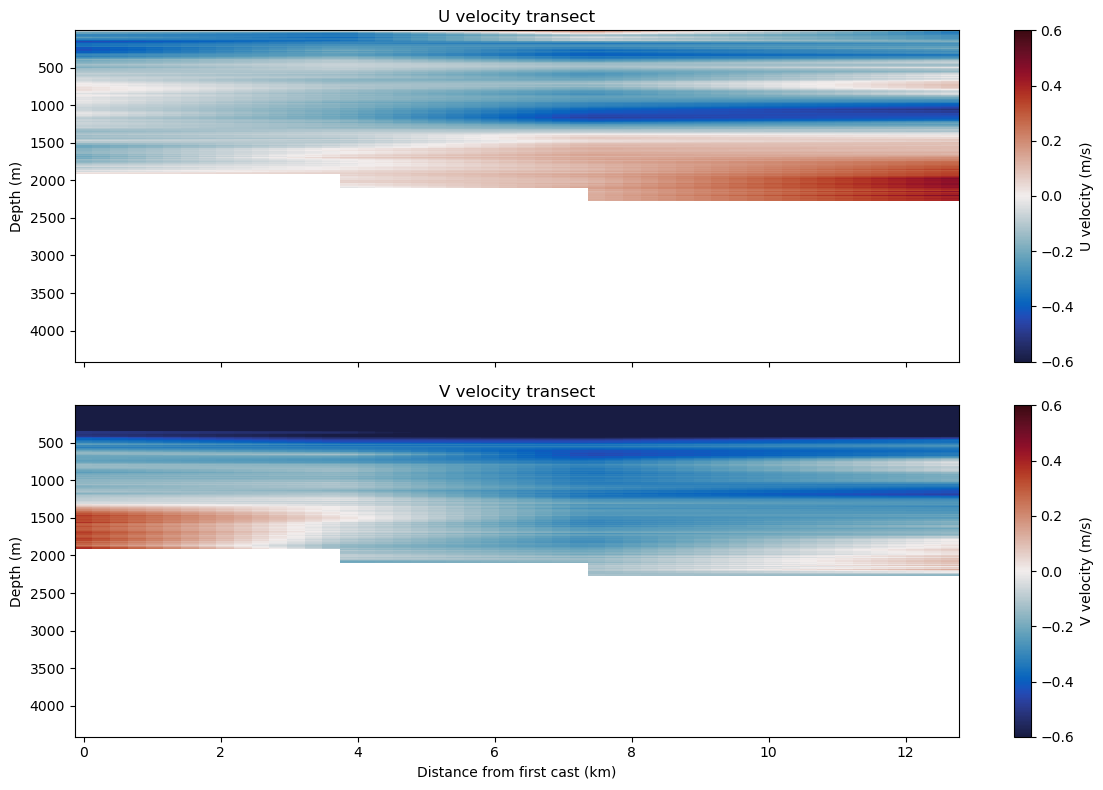

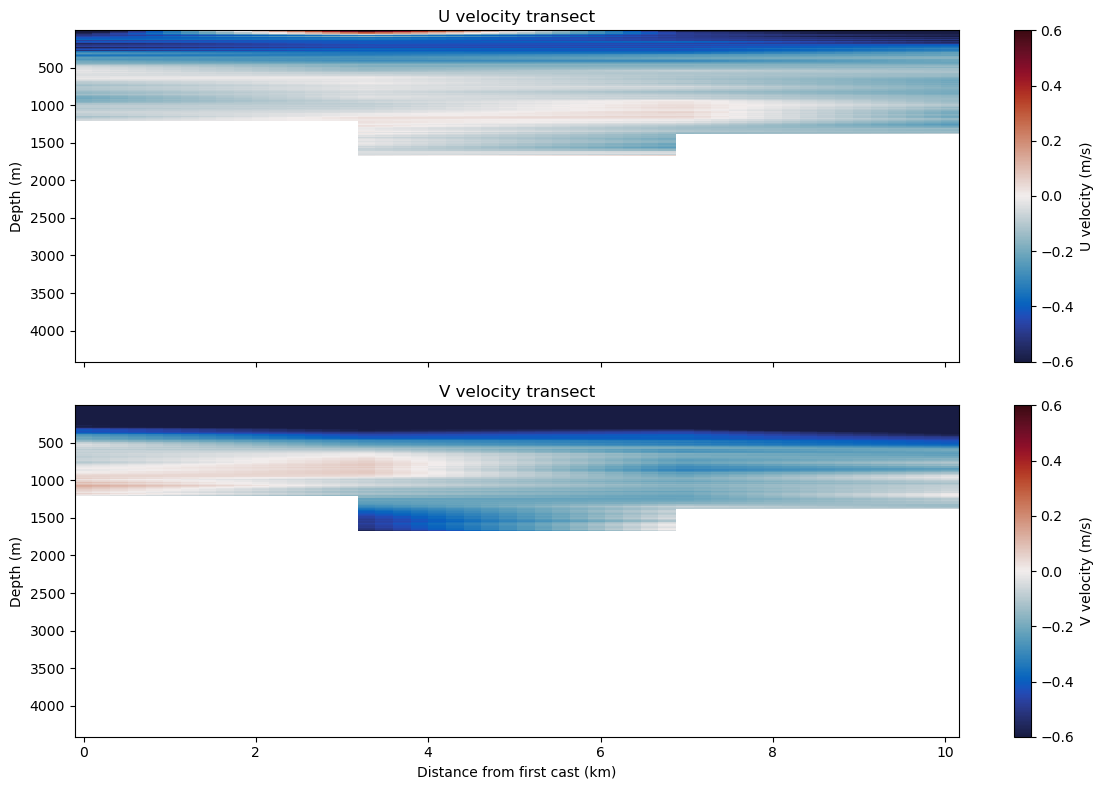

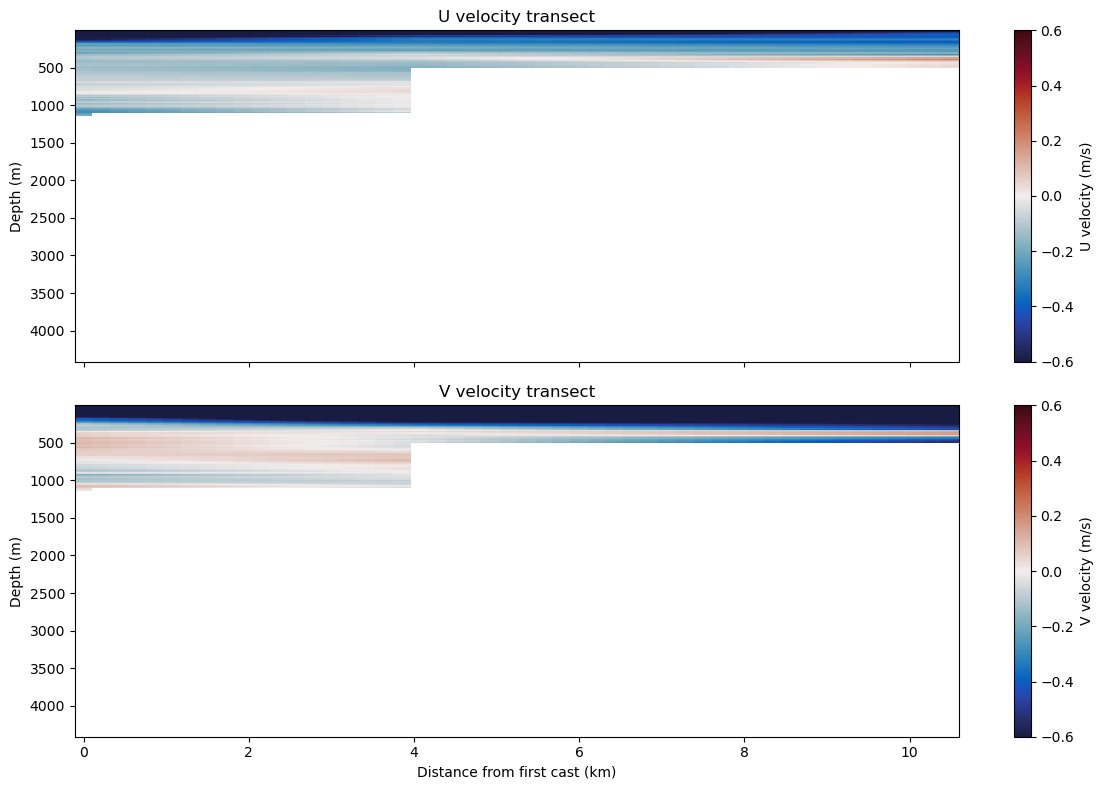

In [49]:
transects = [
    [1, 2, 3, 4],
    [5, 14,12,11,10],
    [7, 6, 8, 9],
    [27, 26, 28, 29],
    [23, 25, 24]
]

# Convert cast to integer for indexing
vels['cast'] = vels['cast'].astype(int)

# Function to calculate distance between two lat/lon points
def calculate_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).km

# Process each transect
for transect in transects:
    first_cast = transect[0]
    first_lat = vels.lat.isel(lat=first_cast).item()
    first_lon = vels.lon.isel(lon=first_cast).item()

    distances = []
    for cast in transect:
        lat = vels.lat.isel(lat=cast).item()
        lon = vels.lon.isel(lon=cast).item()
        distance = calculate_distance(first_lat, first_lon, lat, lon)
        distances.append(distance)
    
    distances = np.array(distances)

    # Interpolating u and v velocities onto a common distance grid
    common_distance = np.linspace(0, distances.max(), num=50)
    u_interpolated = np.zeros((len(common_distance), vels.z.size))
    v_interpolated = np.zeros((len(common_distance), vels.z.size))

    for depth_idx in range(vels.z.size):
        u_values = vels.isel(cast=transect).sel(z=vels.z[depth_idx]).u.values
        v_values = vels.isel(cast=transect).sel(z=vels.z[depth_idx]).v.values
        u_interpolated[:, depth_idx] = np.interp(common_distance, distances, u_values)
        v_interpolated[:, depth_idx] = np.interp(common_distance, distances, v_values)
    
    
    # Plotting the transect
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    c1 = ax1.pcolormesh(common_distance, vels.z, u_interpolated.T, shading='auto', cmap='cmo.balance',vmin=-0.6,vmax=0.6)
    fig.colorbar(c1, ax=ax1, label='U velocity (m/s)')
    ax1.set_ylabel('Depth (m)')
    ax1.set_title('U velocity transect')
    ax1.invert_yaxis()

    c2 = ax2.pcolormesh(common_distance, vels.z, v_interpolated.T, shading='auto', cmap='cmo.balance',vmin=-0.6,vmax=0.6)
    fig.colorbar(c2, ax=ax2, label='V velocity (m/s)')
    ax2.set_ylabel('Depth (m)')
    ax2.set_xlabel('Distance from first cast (km)')
    ax2.set_title('V velocity transect')

    ax2.invert_yaxis()
    plt.tight_layout()
    plt.show()        

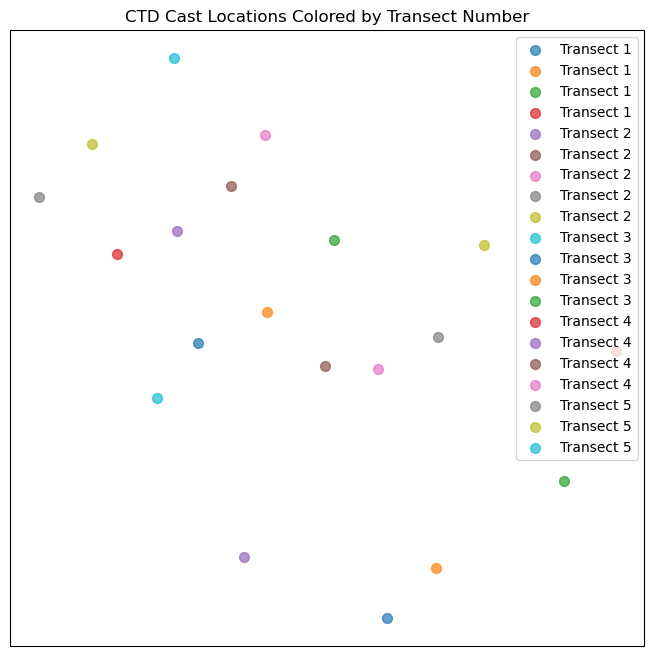

In [44]:
# Example dataset `vels` with 'cast', 'lat', 'lon' coordinates
# Replace with your actual dataset
# Assuming `vels` is an xarray.Dataset or similar structure

# Extract cast, lat, lon from vels dataset
casts = vels['cast'].values.astype(int)
lats = vels['lat'].values
lons = vels['lon'].values

# Create a figure and axis with Cartopy projection
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Add coastline and other features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, color='lightgray', edgecolor='black')

# Plot each cast location colored by transect number
for transect_num, transect in enumerate(transects, start=1):
    for cast_idx in transect:
        cast_lat = lats[cast_idx]
        cast_lon = lons[cast_idx]
        ax.scatter(cast_lon, cast_lat, label=f'Transect {transect_num}', s=50, alpha=0.7)

# Set title and legend
ax.set_title('CTD Cast Locations Colored by Transect Number')
ax.legend()

# Show the plot
plt.show()

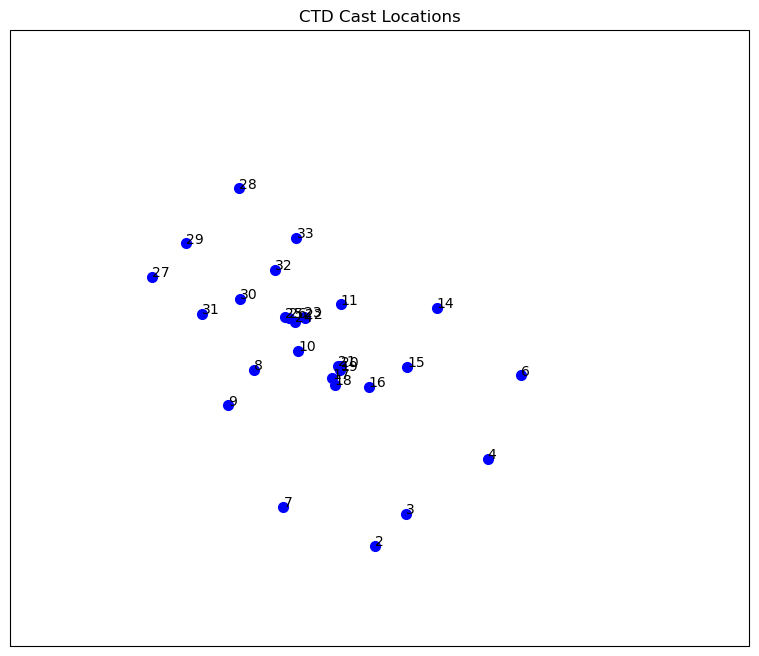

In [48]:
# Example data (replace with your actual data extraction)
latitudes = vels['lat'].values
longitudes = vels['lon'].values
cast_numbers = vels['cast'].values  # Assuming 'cast' is a coordinate in your dataset

def plot_ctd_locations_subset(latitudes, longitudes, cast_numbers, lon_min, lon_max, lat_min, lat_max):
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    

    
    # Find indices of points within the specified extent
    indices = np.where((longitudes >= lon_min) & (longitudes <= lon_max) & 
                       (latitudes >= lat_min) & (latitudes <= lat_max))[0]
    
    # Plot each CTD location within the specified extent
    for idx in indices:
        lat, lon, cast = latitudes[idx], longitudes[idx], cast_numbers[idx]
        ax.plot(lon, lat, 'bo', markersize=7, transform=ccrs.PlateCarree())
        ax.text(lon , lat , str(cast), transform=ccrs.PlateCarree(), fontsize=10)
    
    # Set extent based on the specified range
    buffer = 0.05  # Buffer around the specified extent
    ax.set_extent([lon_min - buffer, lon_max + buffer, lat_min - buffer, lat_max + buffer], crs=ccrs.PlateCarree())
    
    ax.set_title('CTD Cast Locations')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    plt.show()

# Example usage: Plotting subset of CTD cast locations within a specific extent
lon_min, lon_max = 153.5, 154 # Example longitude range
lat_min, lat_max = -30.3, -29.9  # Example latitude range


plot_ctd_locations_subset(latitudes, longitudes, cast_numbers, lon_min, lon_max, lat_min, lat_max)